In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import XGate

In [35]:
a = 3
N = 15
n = N.bit_length()

control_l = []
for i in range(2**(n)):
    control_l.append((bin(i)[2:]).rjust(n,"0"))

data = []
for i in range(2**n):
    data.append((bin(a**i % N)[2:]).rjust(n,"0"))


print(control_l)
print(data)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
['0001', '0011', '1001', '1100', '0110', '0011', '1001', '1100', '0110', '0011', '1001', '1100', '0110', '0011', '1001', '1100']


In [41]:
def dec_to_bin(n, num_vars):
    """Converts a decimal number to its binary representation with a fixed number of bits."""
    return format(n, '0' + str(num_vars) + 'b')

def count_ones(binary_str):
    """Counts the number of '1's in a binary string."""
    return binary_str.count('1')

def find_diff(bin1, bin2):
    """
    Compares two binary strings and returns the differing position if they differ by only one bit,
    otherwise returns -1.
    """
    diff_pos = -1
    diff_count = 0
    for i in range(len(bin1)):
        if bin1[i] != bin2[i]:
            diff_count += 1
            diff_pos = i
    if diff_count == 1:
        return diff_pos
    return -1

def combine_terms(term1, term2):
    """
    Combines two terms (binary strings with dashes) if they differ by only one bit.
    Replaces the differing bit with a dash '-'.
    """
    diff_pos = -1
    diff_count = 0
    for i in range(len(term1)):
        if term1[i] != term2[i]:
            diff_count += 1
            diff_pos = i
    if diff_count == 1:
        combined_term = list(term1)
        combined_term[diff_pos] = '-'
        return "".join(combined_term)
    return None

def get_literal(term, variables):
    """
    Converts a binary term (with dashes) into its literal representation (e.g., 'A', 'B'', 'C').
    """
    literal = []
    for i, char in enumerate(term):
        if char == '1':
            literal.append(variables[i])
        elif char == '0':
            literal.append(variables[i] + "'")
    return "".join(literal)

def minimize_boolean_expression(minterms, num_vars, variables):
    """
    Minimizes a Boolean expression using the Quine-McCluskey algorithm.

    Args:
        minterms (list): A list of decimal minterms (where the output is '1').
        num_vars (int): The number of input variables.
        variables (list): A list of characters representing the variables (e.g., ['A', 'B', 'C']).

    Returns:
        str: The minimized Boolean expression in Sum-of-Products (SOP) form.
    """
    if not minterms:
        return "0"  # No minterms, expression is always false

    # Step 1: Convert minterms to binary and group by number of '1's
    groups = {}
    for m in minterms:
        binary_m = dec_to_bin(m, num_vars)
        ones_count = count_ones(binary_m)
        if ones_count not in groups:
            groups[ones_count] = []
        groups[ones_count].append(binary_m)

    implicants = []
    prime_implicants = set()
    marked = set() # To keep track of terms that have been combined

    current_groups = groups
    while True:
        next_groups = {}
        combined_this_pass = False
        
        sorted_keys = sorted(current_groups.keys())
        for i in range(len(sorted_keys)):
            for term1 in current_groups[sorted_keys[i]]:
                for j in range(i + 1, len(sorted_keys)):
                    # Check if next group key exists and is just one greater
                    if sorted_keys[j] == sorted_keys[i] + 1:
                        for term2 in current_groups[sorted_keys[j]]:
                            combined = combine_terms(term1, term2)
                            if combined:
                                combined_this_pass = True
                                
                                # Add to next_groups
                                ones_count = count_ones(combined.replace('-', '')) # Count 1s excluding dashes
                                if ones_count not in next_groups:
                                    next_groups[ones_count] = []
                                if combined not in next_groups[ones_count]:
                                    next_groups[ones_count].append(combined)

                                # Mark the original terms as combined
                                marked.add(term1)
                                marked.add(term2)
                                
        # Add unmarked terms from current_groups to prime_implicants
        for group_key in current_groups:
            for term in current_groups[group_key]:
                if term not in marked:
                    prime_implicants.add(term)

        current_groups = next_groups
        marked.clear() # Clear marked for the next pass
        
        if not combined_this_pass:
            break # No more combinations possible

    # Add any remaining terms from the last pass that weren't marked
    for group_key in current_groups:
        for term in current_groups[group_key]:
            prime_implicants.add(term)

    # Step 2: Create the Prime Implicant Chart
    # This part involves finding essential prime implicants and covering remaining minterms.
    # For simplicity, we'll use a slightly less optimized but functional approach for this example.
    
    # Convert prime implicants to a list for easier indexing
    prime_implicants_list = list(prime_implicants)
    
    # Create a coverage matrix: rows are prime implicants, columns are minterms
    coverage_matrix = {}
    for pi_index, pi in enumerate(prime_implicants_list):
        coverage_matrix[pi] = []
        for m in minterms:
            binary_m = dec_to_bin(m, num_vars)
            
            # Check if the prime implicant covers the minterm
            covers = True
            for i in range(num_vars):
                if pi[i] != '-' and pi[i] != binary_m[i]:
                    covers = False
                    break
            if covers:
                coverage_matrix[pi].append(m)

    essential_prime_implicants = set()
    covered_minterms = set()

    # Find essential prime implicants
    for m in minterms:
        covering_pis = []
        for pi in prime_implicants_list:
            if m in coverage_matrix[pi]:
                covering_pis.append(pi)
        
        if len(covering_pis) == 1:
            essential_prime_implicants.add(covering_pis[0])
            covered_minterms.add(m)

    # Add essential prime implicants to the final solution
    final_solution_pis = list(essential_prime_implicants)
    
    # Remove covered minterms from the list of minterms to be covered
    remaining_minterms = set(minterms) - covered_minterms

    # If there are still remaining minterms, select additional prime implicants
    # This part is a heuristic simplification for pedagogical purposes.
    # A full Quine-McCluskey would use Petrick's method or a more sophisticated covering algorithm.
    while remaining_minterms:
        best_pi = None
        max_new_coverage = 0
        
        for pi in prime_implicants_list:
            if pi not in final_solution_pis:
                new_coverage = len(set(coverage_matrix[pi]) & remaining_minterms)
                if new_coverage > max_new_coverage:
                    max_new_coverage = new_coverage
                    best_pi = pi
        
        if best_pi:
            final_solution_pis.append(best_pi)
            remaining_minterms -= set(coverage_matrix[best_pi])
        else:
            # This should ideally not happen if minterms are truly coverable by prime implicants
            break 
            
    # Step 3: Convert selected prime implicants to the Boolean expression
    minimized_expression_terms = []
    for pi in final_solution_pis:
        minimized_expression_terms.append(get_literal(pi, variables))

    return " + ".join(minimized_expression_terms)

def cria_circuito_tabela(data: list[str], n):
    reg_c = QuantumRegister(n, "control")
    reg_data = QuantumRegister(n, "d")

    qc = QuantumCircuit(reg_c, reg_data)

    control_l = []
    for i in range(2**(n)):
        control_l.append((bin(i)[2:]).rjust(n,"0"))


    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] == "1":
                qc.append(XGate().control(num_ctrl_qubits=n, ctrl_state=control_l[i]), reg_c[:] + reg_data[j:j+1])

    return qc

minterms = [0,1,2,5,6,9,10,13,14]
num_vars = 4
variables = ["0", "1", "2", "3"]

minimized_expr = minimize_boolean_expression(minterms, num_vars, variables)

print(f"Minimizing F({', '.join(variables)}) = sum({minterms}):")
print(f"Minimized expression: {minimized_expr}\n") # Expected: -C . -D



Minimizing F(0, 1, 2, 3) = sum([0, 1, 2, 5, 6, 9, 10, 13, 14]):
Minimized expression: 2'3 + 23' + 0'1'2' + 0'1'3'



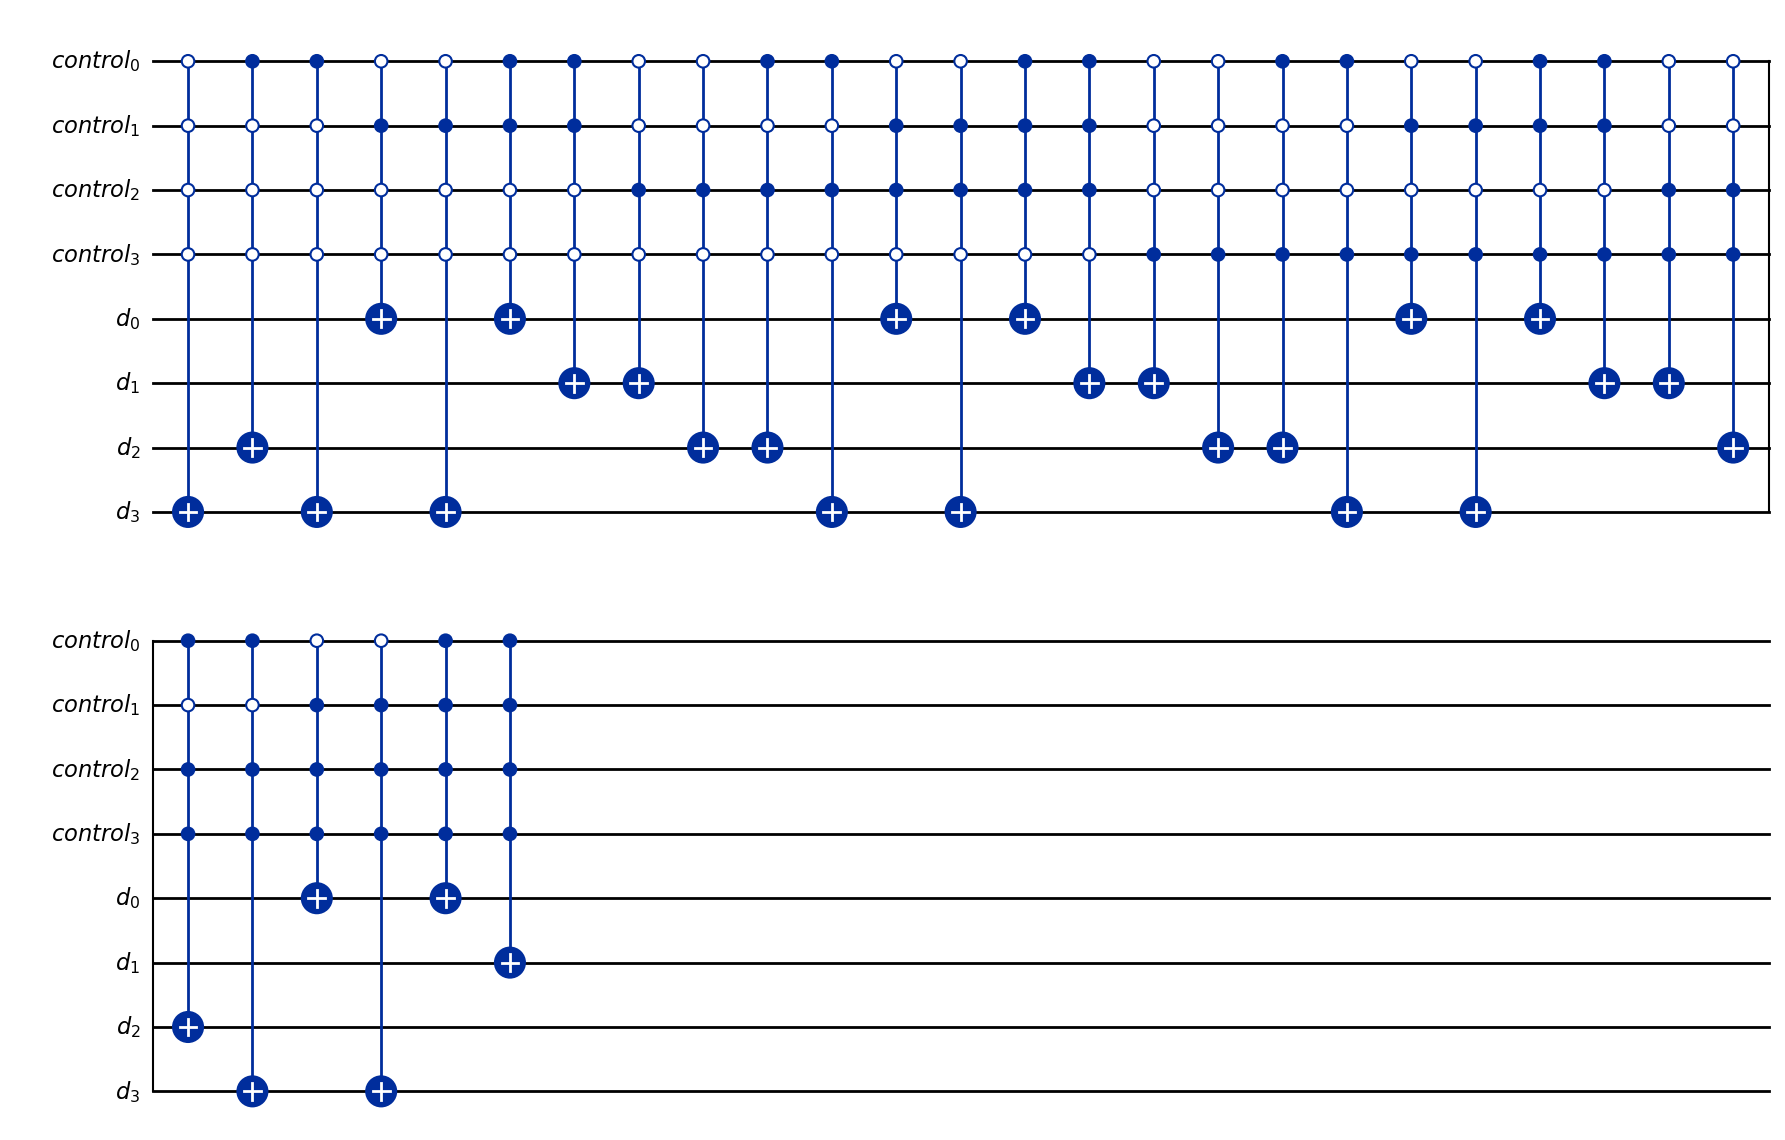

In [42]:
cria_circuito_tabela(data, n).draw("mpl")

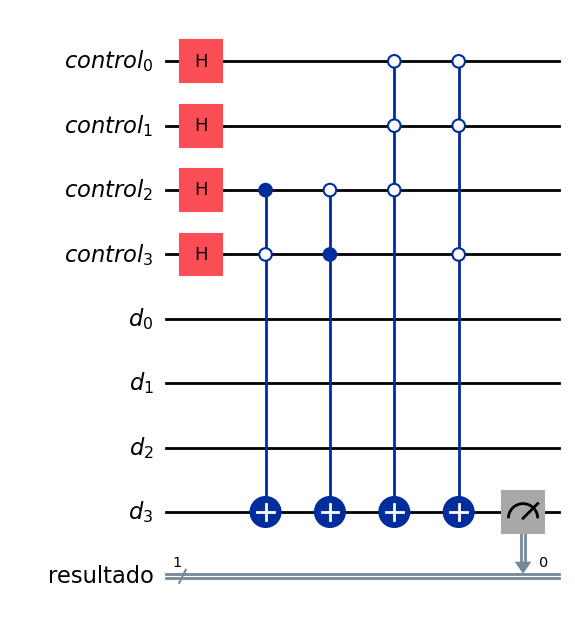

In [43]:
reg_c = QuantumRegister(n, "control")
reg_data = QuantumRegister(n, "d")
reg_result = ClassicalRegister(1, "resultado")

qc = QuantumCircuit(reg_c, reg_data, reg_result)

qc.h(reg_c)

#qc.append(cria_circuito_tabela(data, n), reg_c[:] + reg_data[:])
qc.append(XGate().control(num_ctrl_qubits=2, ctrl_state="01"), reg_c[2:] + reg_data[3:4])
qc.append(XGate().control(num_ctrl_qubits=2, ctrl_state="10"), reg_c[2:] + reg_data[3:4])
qc.append(XGate().control(num_ctrl_qubits=3, ctrl_state="000"), reg_c[0:3] + reg_data[3:4])
qc.append(XGate().control(num_ctrl_qubits=3, ctrl_state="000"), reg_c[0:2] + reg_c[3:] + reg_data[3:4])


qc.measure(reg_data[-1], reg_result)

qc.draw("mpl")

In [44]:
from qiskit_aer import AerSimulator
from qiskit import transpile

backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1)

from qiskit.primitives import StatevectorSampler

statevectorsampler = StatevectorSampler()
pub = (qc1)
job = statevectorsampler.run([pub], shots=2**14)
print(job.result()[0].data.resultado.get_int_counts())

Resultado = job.result()[0].data.resultado.get_int_counts()

for i in range(1<<(n)):
  if i not in Resultado:
    Resultado[i] = 1

{0: 10175, 1: 6209}


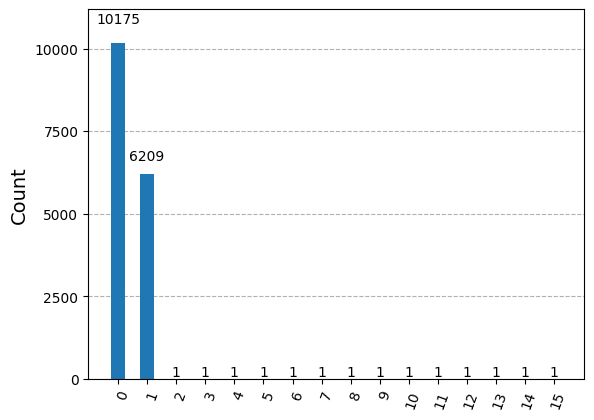

In [45]:
from qiskit.visualization import plot_histogram

plot_histogram(Resultado)